# oce0, variable GammaT/S

In [1]:
import sys
sys.path.append("../")
import glob
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
%matplotlib notebook
from matplotlib import cm
from netCDF4 import Dataset,MFDataset

%load_ext autoreload
%autoreload 2

import pyfesom as pf
%aimport pyfesom

no cmocean


## equilibration?

In [2]:
meshpath_z = '/work/ollie/orichter/mesh/oce0_z'
mesh_z = pf.fesom_mesh(meshpath_z, abg=[0,0,0],cavity=False) ## for melt rate we need to deactivate cavity
diag_z = MFDataset(sorted(glob.glob('/work/ollie/orichter/data/oce0_z/RG47911.202?.forcing.diag.nc')))
diag_z_cold = MFDataset(sorted(glob.glob('/work/ollie/orichter/data/oce0cold_z/RG47911.202?.forcing.diag.nc')))

meshpath_s = '/work/ollie/orichter/mesh/oce0_s'
mesh_s = pf.fesom_mesh(meshpath_s, abg=[0,0,0],cavity='sigma') ## for melt rate we need to deactivate cavity
diag_s = MFDataset(sorted(glob.glob('/work/ollie/orichter/data/oce0_s/RG47911.202?.forcing.diag.nc')))
diag_s_cold = MFDataset(sorted(glob.glob('/work/ollie/orichter/data/oce0cold_s/RG47911.202?.forcing.diag.nc')))

Load 2d part of the grid in 0 second(s)
Load 3d part of the grid in 0 seconds
Load 2d part of the grid in 0 second(s)
Load 3d part of the grid in 0 seconds


In [4]:
def get_mean_melt(mesh,wnet3d):
    nod2d = np.arange(mesh.n2d)
    nod_melt = nod2d[mesh.zcoord[nod2d]>300]
    mean_melt = np.mean(wnet3d[:,nod_melt]*3600*24*365.25,1)
    
    return mean_melt

## how about grid slope? sigma should have a larger area than z. sigma should also be weighted by element area?

<IPython.core.display.Javascript object>


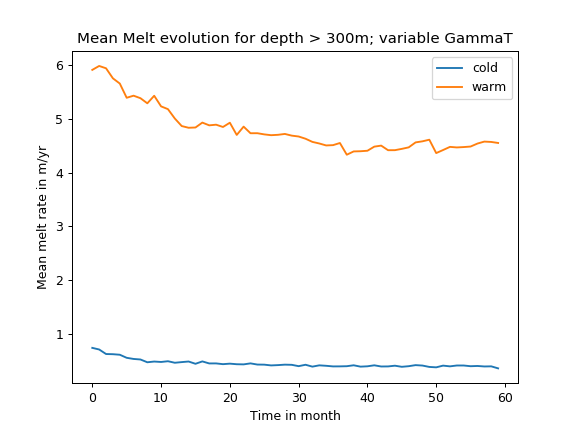

In [13]:
s_warm = get_mean_melt(mesh_s,diag_s.variables['wnet'][1:])
s_cold = get_mean_melt(mesh_s,diag_s_cold.variables['wnet'][1:])

plt.close()
plt.figure()
plt.plot(s_cold,label='cold')
plt.plot(s_warm,label='warm')
plt.legend()
plt.xlabel('Time in month')
plt.ylabel('Mean melt rate in m/yr')
plt.title('Mean Melt evolution for depth > 300m; variable GammaT')
#plt.ylim(bottom=0)
plt.show()

### warm case

<IPython.core.display.Javascript object>


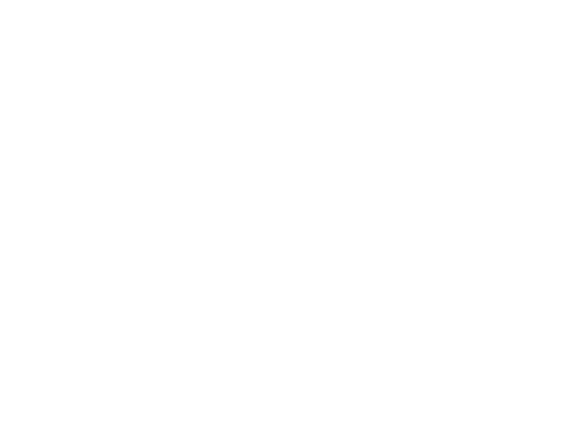

In [4]:
mm_z = get_mean_melt(mesh_z,diag_z.variables['wnet'][1:])
mm_s = get_mean_melt(mesh_s,diag_s.variables['wnet'][1:])

plt.close()
plt.figure()
plt.plot(mm_z,label='z')
plt.plot(mm_s,label='sigma')
plt.legend()
plt.xlabel('Time in month')
plt.ylabel('Mean melt rate in m/yr')
plt.title('Mean Melt evolution for depth > 300m; variable GammaT; warm case')
plt.show()

### cold case

<IPython.core.display.Javascript object>


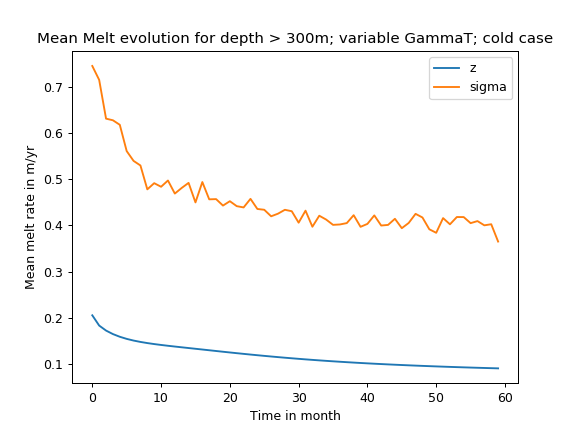

In [5]:
mm_z = get_mean_melt(mesh_z,diag_z_cold.variables['wnet'][1:])
mm_s = get_mean_melt(mesh_s,diag_s_cold.variables['wnet'][1:])

plt.close()
plt.figure()
plt.plot(mm_z,label='z')
plt.plot(mm_s,label='sigma')
plt.legend()
plt.xlabel('Time in month')
plt.ylabel('Mean melt rate in m/yr')
plt.title('Mean Melt evolution for depth > 300m; variable GammaT; cold case')
plt.show()

## diff melt distribution

In [5]:
def plot_melt_map(mesh,wnet2d,sigma=False,title=False,levels='auto'):
    plt.figure(figsize=(8.27,7))
    if sigma:
        level_data, elem_no_nan = pf.get_data_sigma(wnet2d,mesh,0)
    else:
        level_data, elem_no_nan = pf.get_data(wnet2d,mesh,0)
    level_data = level_data*365.25*24*3600
    #levels = np.arange(-0.05, 22.0, 0.05)
    if levels=='auto':
        levels = np.linspace(level_data.min(),level_data.max(),10)
    plt.tricontourf(mesh.x2, mesh.y2, elem_no_nan[::], level_data, levels = levels, cmap=cm.Spectral_r, extend='both')
    cbar = plt.colorbar(orientation='horizontal', pad=0.04);
    cbar.set_label("Melt rate in m/yr")
    if title:
        plt.title(title)
    plt.xlim(xmax=6)
    plt.tight_layout()
    plt.show()

### warm

For depth 0 model level -0.0 will be used


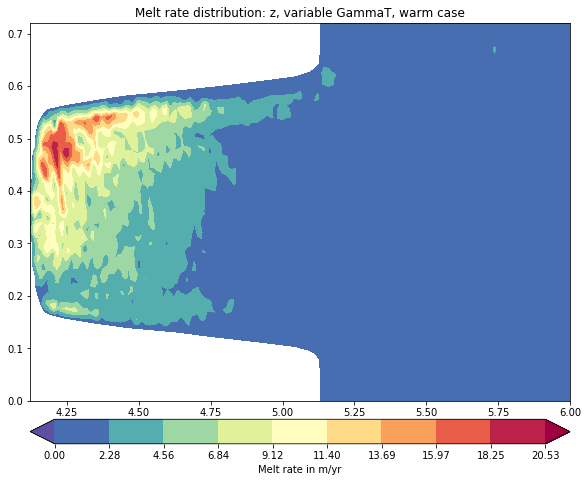

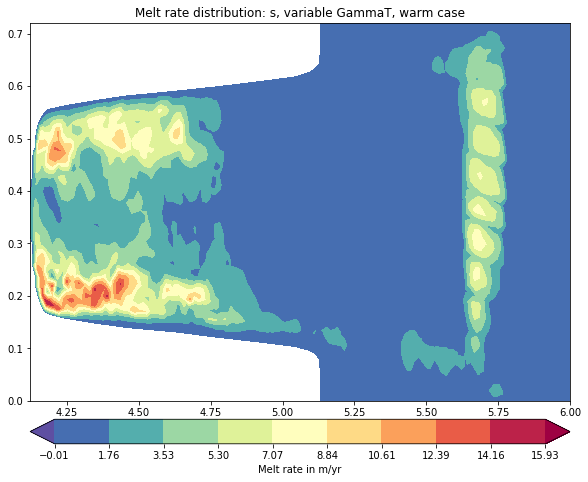

For depth 0 model level -0.0 will be used


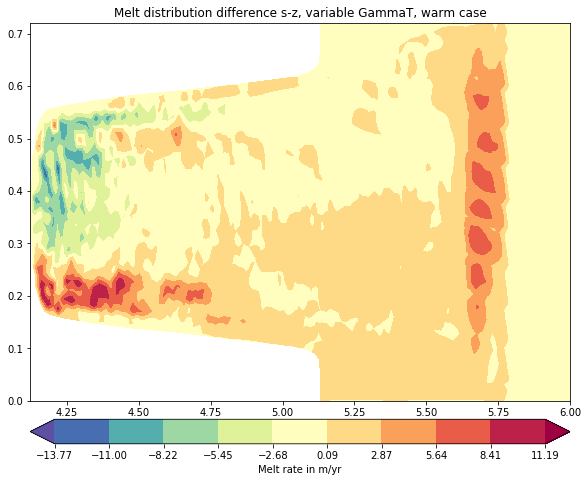

In [16]:
%matplotlib inline
plot_melt_map(mesh_z,np.mean(diag_z['wnet'][-6:],0),title='Melt rate distribution: z, variable GammaT, warm case')
plot_melt_map(mesh_s,np.mean(diag_s['wnet'][-6:],0),1,title='Melt rate distribution: s, variable GammaT, warm case')
plot_melt_map(mesh_z,np.mean(diag_s['wnet'][-6:],0)-np.mean(diag_z['wnet'][-6:],0),title='Melt distribution difference s-z, variable GammaT, warm case')

### cold

For depth 0 model level -0.0 will be used


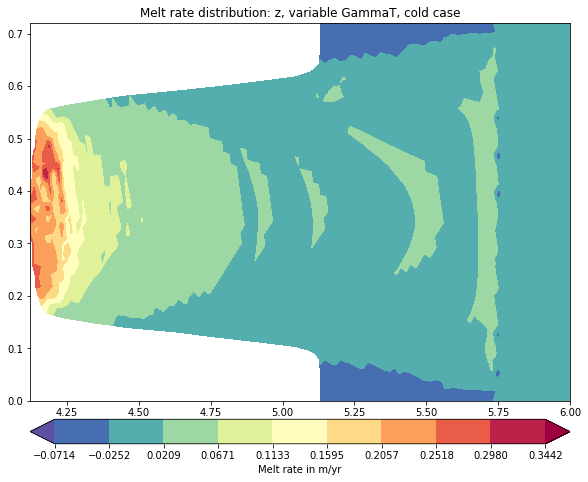

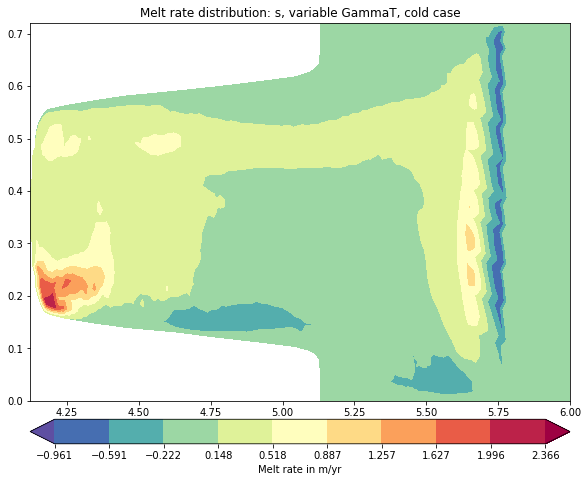

For depth 0 model level -0.0 will be used


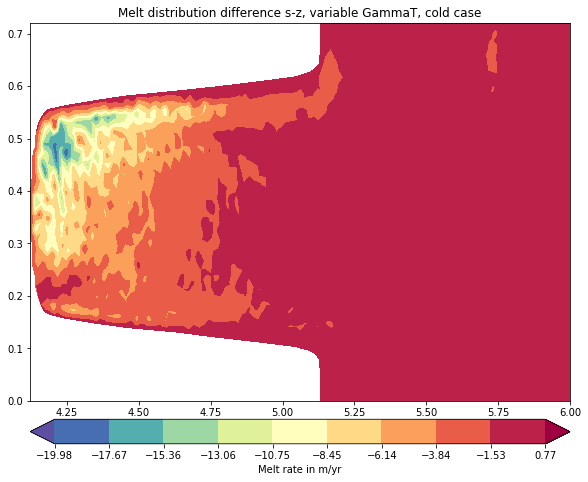

In [8]:
%matplotlib inline
plot_melt_map(mesh_z,np.mean(diag_z_cold['wnet'][-6:],0),title='Melt rate distribution: z, variable GammaT, cold case')
plot_melt_map(mesh_s,np.mean(diag_s_cold['wnet'][-6:],0),1,title='Melt rate distribution: s, variable GammaT, cold case')
plot_melt_map(mesh_z,np.mean(diag_s_cold['wnet'][-6:],0)-np.mean(diag_z['wnet'][-6:],0),title='Melt distribution difference s-z, variable GammaT, cold case')

## diff temp transect

In [10]:
mesh_z = pf.fesom_mesh(meshpath_z, abg=[0,0,0], cavity=True) #for transects we need the cavity flag
basedir='/work/ollie/orichter/'
oce_z = Dataset(basedir+'data/oce0_z/RG47911.2025.oce.nc')
oce_s = Dataset(basedir+'data/oce0_s/RG47911.2025.oce.nc')
oce_z_cold = Dataset(basedir+'data/oce0cold_z/RG47911.2025.oce.nc')
oce_s_cold = Dataset(basedir+'data/oce0cold_s/RG47911.2025.oce.nc')

Load 2d part of the grid in 0 second(s)
correct for cavity
Load 3d part of the grid in 0 seconds


In [6]:
def plot_trans(mesh,data3d,title,sigma=False,clabel=False,levels='auto'):
    npoints = 1000
    lon_start = min(mesh.x2)
    lat_start = np.mean(mesh.y2)
    lon_end   = max(mesh.x2)
    lat_end   = np.mean(mesh.y2)
    if levels=='auto':
        levels = np.linspace(min(data3d),max(data3d))
    
    fig, ax = plt.subplots(1,1, figsize=(8.27,5))
    if sigma:
        image = pf.plot_transect_sigma(data3d, mesh, 
                         lon_start,
                         lat_start,
                         lon_end,
                         lat_end,
                         npoints=npoints,
                         #levels = np.round(np.linspace(-2, 2, 42),2),
                         
                         levels = levels,
                         #levels = np.linspace(-0.02,0.02),
                         cmap=cm.Spectral_r,
                         #cmap=cm.bwr,
                         maxdepth =6000,
                         title = title,
                         ncols=1,
                         figsize=(5,10),
                        ax = ax
                        )
    else:
        image = pf.plot_transect(data3d, mesh, 
                                 lon_start,
                                 lat_start,
                                 lon_end,
                                 lat_end,
                                 npoints=npoints,
                                 #levels = np.round(np.linspace(-2, 2, 42),2),
                                 levels = levels,
                                 #levels = np.linspace(-0.02,0.02),
                                 cmap=cm.Spectral_r,
                                 #cmap=cm.bwr,
                                 maxdepth =6000,
                                 title = title,
                                 ncols=1,
                                 figsize=(5,10),
                                ax = ax)
    cb = fig.colorbar(image, orientation='horizontal', ax=ax, pad=0.13)
    if clabel:                            
        cb.set_label(clabel)

### warm

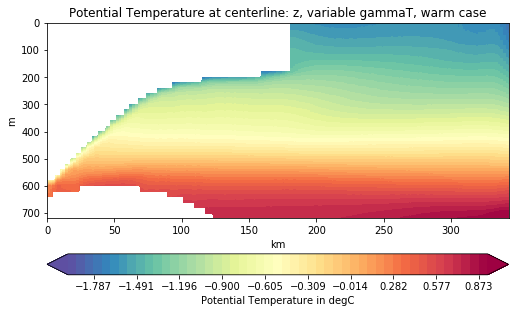

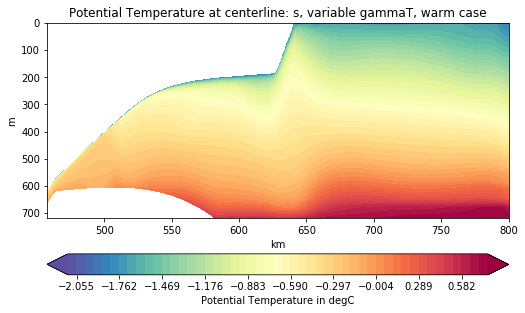

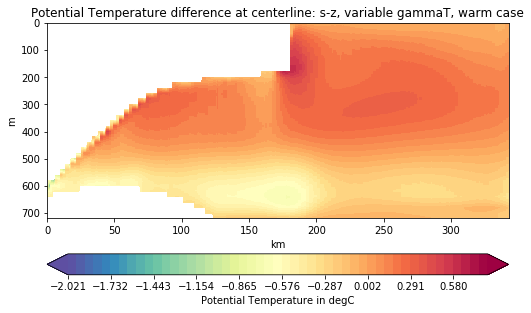

In [23]:
plot_trans(mesh_z,np.mean(oce_z['temp'][-6:],axis=0),'Potential Temperature at centerline: z, variable gammaT, warm case',
           sigma=False,clabel='Potential Temperature in degC')
plot_trans(mesh_s,np.mean(oce_s['temp'][-6:],0),'Potential Temperature at centerline: s, variable gammaT, warm case',sigma=True,clabel='Potential Temperature in degC')
temp_s_on_z = pf.interp_sigma2z(mesh_s,np.mean(oce_s['temp'][-6:],0),mesh_z)
temp_diff = temp_s_on_z - np.mean(oce_z['temp'][-6:],0)
plot_trans(mesh_z,temp_diff,'Potential Temperature difference at centerline: s-z, variable gammaT, warm case',sigma=False,clabel='Potential Temperature in degC')

### cold

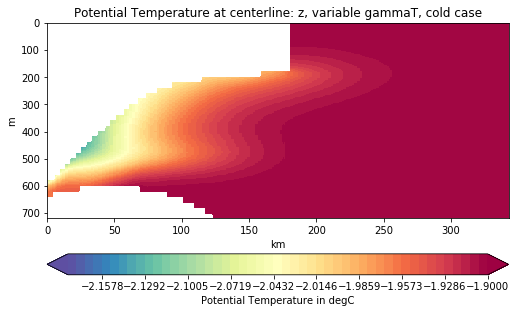

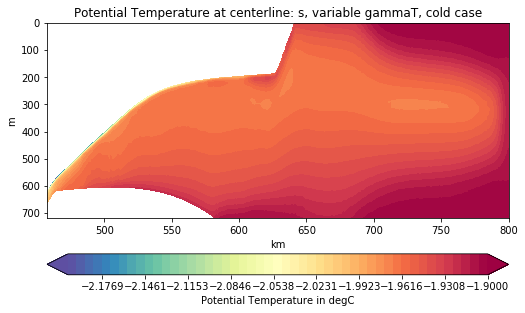

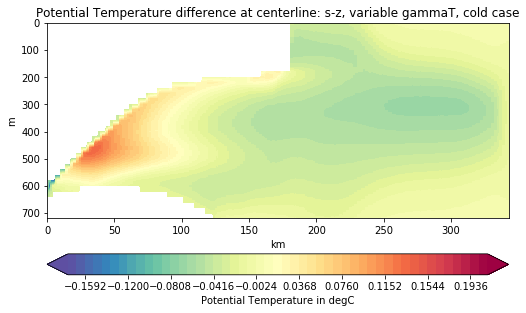

In [12]:
plot_trans(mesh_z,np.mean(oce_z_cold['temp'][-6:],axis=0),'Potential Temperature at centerline: z, variable gammaT, cold case',
           sigma=False,clabel='Potential Temperature in degC')
plot_trans(mesh_s,np.mean(oce_s_cold['temp'][-6:],0),'Potential Temperature at centerline: s, variable gammaT, cold case',sigma=True,clabel='Potential Temperature in degC')
temp_s_on_z = pf.interp_sigma2z(mesh_s,np.mean(oce_s_cold['temp'][-6:],0),mesh_z)
temp_diff = temp_s_on_z - np.mean(oce_z_cold['temp'][-6:],0)
plot_trans(mesh_z,temp_diff,'Potential Temperature difference at centerline: s-z, variable gammaT, cold case',sigma=False,clabel='Potential Temperature in degC')

# oce0, tuned GammaT/S
## warm

In [2]:
meshpath_z = '/work/ollie/orichter/mesh/oce0_z'
mesh_z = pf.fesom_mesh(meshpath_z, abg=[0,0,0],cavity=False) ## for melt rate we need to deactivate cavity
diag_z = MFDataset(sorted(glob.glob('/work/ollie/orichter/data/oce0_z_0.12/RG47911.202?.forcing.diag.nc')))

meshpath_s = '/work/ollie/orichter/mesh/oce0_s'
mesh_s = pf.fesom_mesh(meshpath_s, abg=[0,0,0],cavity='sigma') ## for melt rate we need to deactivate cavity
diag_s = MFDataset(sorted(glob.glob('/work/ollie/orichter/data/oce0_s_0.12/RG47911.202?.forcing.diag.nc')))

Load 2d part of the grid in 0 second(s)
Load 3d part of the grid in 0 seconds
Load 2d part of the grid in 0 second(s)
Load 3d part of the grid in 0 seconds


For depth 0 model level -0.0 will be used


/global/AWIsoft/intel/2018/intelpython2/lib/python2.7/site-packages/ipykernel_launcher.py:9: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if __name__ == '__main__':


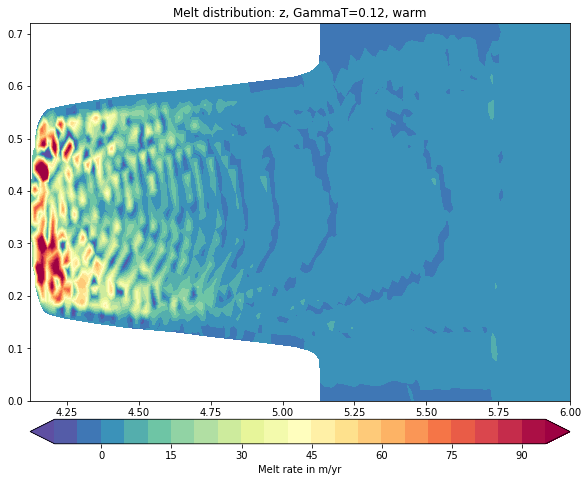

For depth 0 model level 0.0 will be used


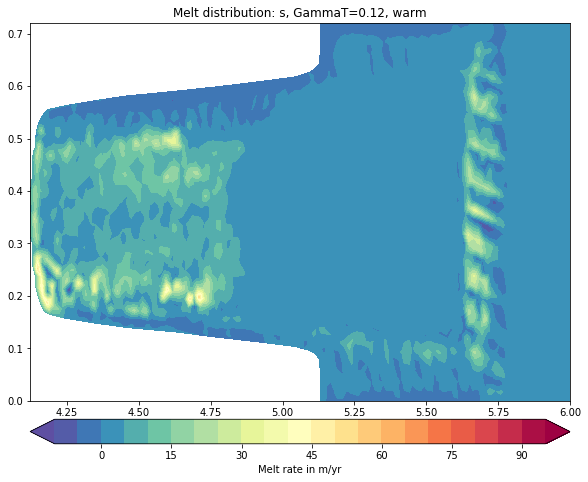

For depth 0 model level -0.0 will be used


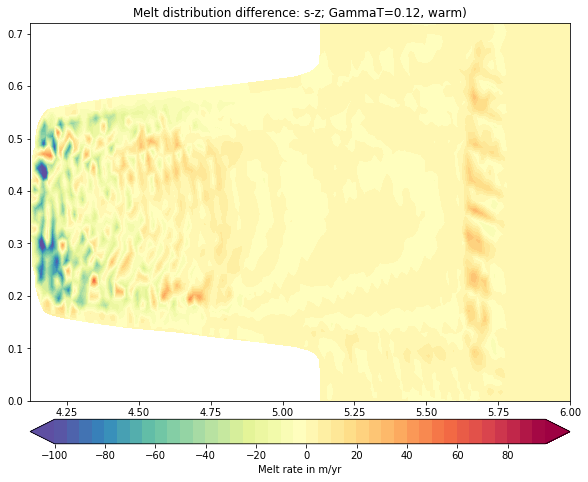

In [7]:
%matplotlib inline
plot_melt_map(mesh_z,np.mean(diag_z['wnet'][-6:],0),title='Melt distribution: z, GammaT=0.12, warm',levels=np.arange(-10,100,5))
plot_melt_map(mesh_s,np.mean(diag_s['wnet'][-6:],0),title='Melt distribution: s, GammaT=0.12, warm',levels=np.arange(-10,100,5))
plot_melt_map(mesh_z,np.mean(diag_s['wnet'][-6:],0)-np.mean(diag_z['wnet'][-6:],0),
              title='Melt distribution difference: s-z; GammaT=0.12, warm)',levels=np.arange(-100,100,5))

In [8]:
mesh_z = pf.fesom_mesh(meshpath_z, abg=[0,0,0], cavity=True) #for transects we need the cavity flag
basedir='/work/ollie/orichter/'
oce_z = Dataset(basedir+'data/oce0_z_0.12/RG47911.2023.oce.nc')
oce_s = Dataset(basedir+'data/oce0_s_0.12/RG47911.2023.oce.nc')

Load 2d part of the grid in 0 second(s)
correct for cavity
Load 3d part of the grid in 0 seconds


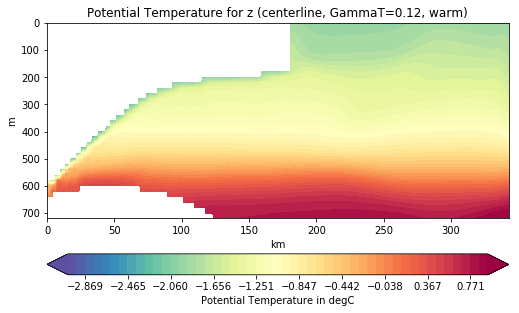

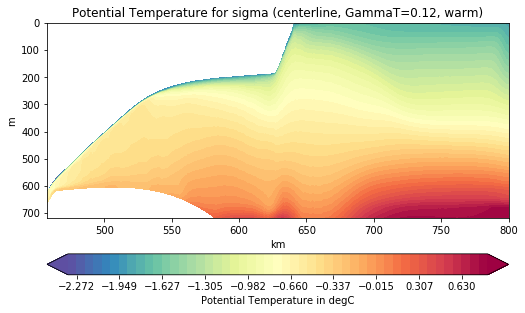

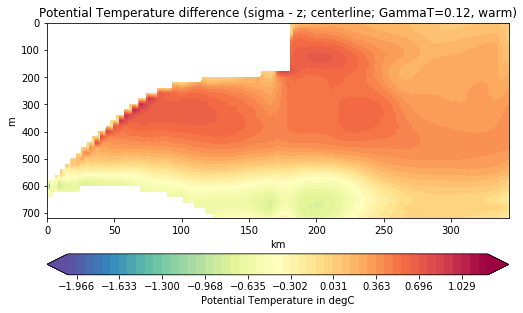

In [9]:
plot_trans(mesh_z,np.mean(oce_z['temp'][-6:],axis=0),'Potential Temperature for z (centerline, GammaT=0.12, warm)',
           sigma=False,clabel='Potential Temperature in degC')
plot_trans(mesh_s,np.mean(oce_s['temp'][-6:],0),'Potential Temperature for sigma (centerline, GammaT=0.12, warm)',sigma=True,clabel='Potential Temperature in degC')
temp_s_on_z = pf.interp_sigma2z(mesh_s,np.mean(oce_s['temp'][-6:],0),mesh_z)
temp_diff = temp_s_on_z - np.mean(oce_z['temp'][-6:],0)
plot_trans(mesh_z,temp_diff,'Potential Temperature difference (sigma - z; centerline; GammaT=0.12, warm)',sigma=False,
           clabel='Potential Temperature in degC')

## cold

In [14]:
meshpath_z = '/work/ollie/orichter/mesh/oce0_z'
mesh_z = pf.fesom_mesh(meshpath_z, abg=[0,0,0],cavity=False) ## for melt rate we need to deactivate cavity
diag_z = MFDataset(sorted(glob.glob('/work/ollie/orichter/data/oce0cold_z_0.04/RG47911.202?.forcing.diag.nc')))

meshpath_s = '/work/ollie/orichter/mesh/oce0_s'
mesh_s = pf.fesom_mesh(meshpath_s, abg=[0,0,0],cavity='sigma') ## for melt rate we need to deactivate cavity
diag_s = MFDataset(sorted(glob.glob('/work/ollie/orichter/data/oce0cold_s_0.04/RG47911.202?.forcing.diag.nc')))

Load 2d part of the grid in 0 second(s)
Load 3d part of the grid in 0 seconds
Load 2d part of the grid in 0 second(s)
Load 3d part of the grid in 0 seconds


For depth 0 model level -0.0 will be used


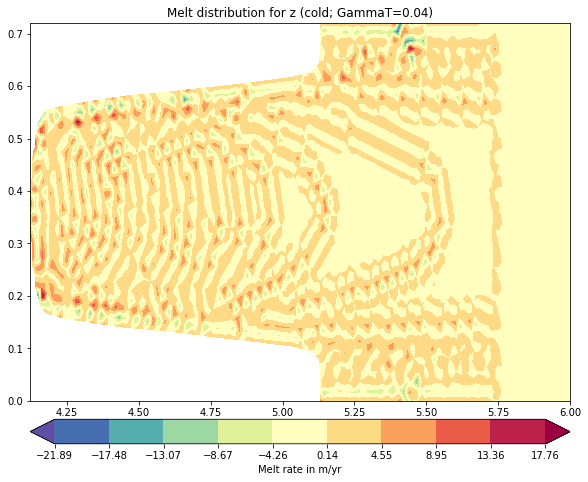

For depth 0 model level 0.0 will be used


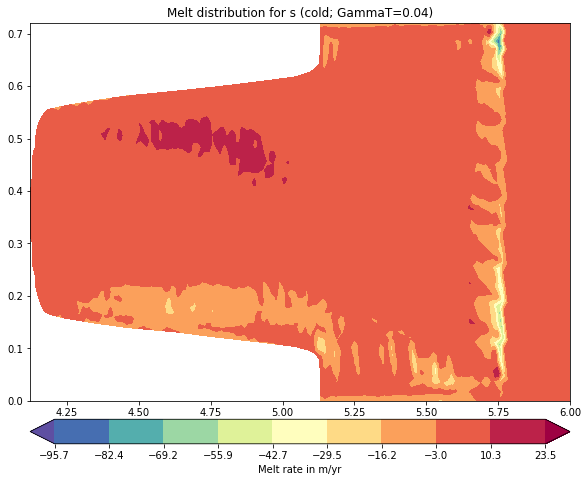

For depth 0 model level -0.0 will be used


/global/AWIsoft/intel/2018/intelpython2/lib/python2.7/site-packages/ipykernel_launcher.py:9: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if __name__ == '__main__':


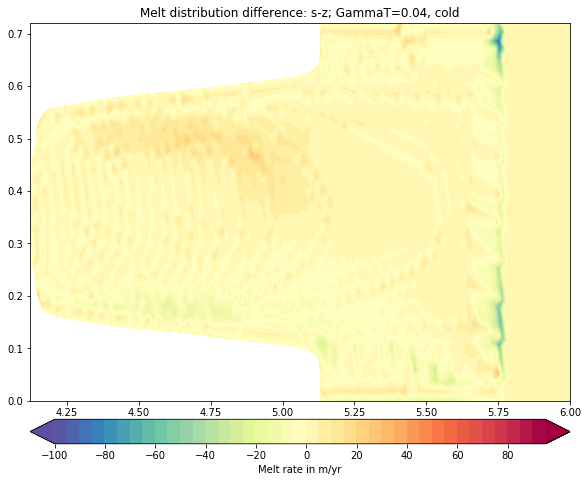

In [15]:
plot_melt_map(mesh_z,np.mean(diag_z['wnet'][-6:],0),title='Melt distribution for z (cold; GammaT=0.04)')#,levels=np.arange(-10,100,5))
plot_melt_map(mesh_s,np.mean(diag_s['wnet'][-6:],0),title='Melt distribution for s (cold; GammaT=0.04)')#,levels=np.arange(-10,100,5))
plot_melt_map(mesh_z,np.mean(diag_s['wnet'][-6:],0)-np.mean(diag_z['wnet'][-6:],0),
              title='Melt distribution difference: s-z; GammaT=0.04, cold',levels=np.arange(-100,100,5))

Load 2d part of the grid in 0 second(s)
correct for cavity
Load 3d part of the grid in 0 seconds


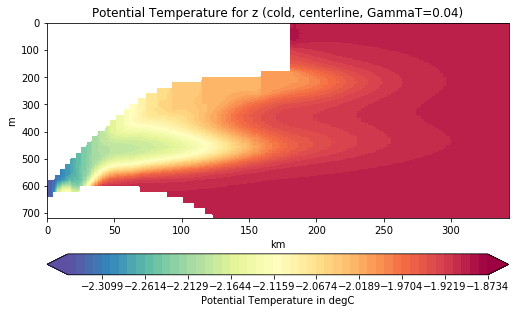

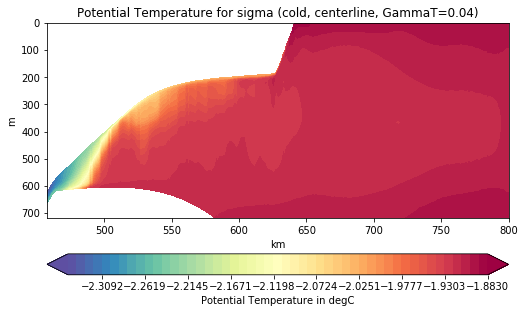

In [16]:
mesh_z = pf.fesom_mesh(meshpath_z, abg=[0,0,0], cavity=True) #for transects we need the cavity flag
basedir='/work/ollie/orichter/'
oce_z = Dataset(basedir+'data/oce0cold_z_0.02/RG47911.2023.oce.nc')
oce_s = Dataset(basedir+'data/oce0cold_s_0.02/RG47911.2023.oce.nc')
plot_trans(mesh_z,np.mean(oce_z['temp'][-6:],axis=0),'Potential Temperature for z (cold, centerline, GammaT=0.04)',
           sigma=False,clabel='Potential Temperature in degC')
plot_trans(mesh_s,np.mean(oce_s['temp'][-6:],0),'Potential Temperature for sigma (cold, centerline, GammaT=0.04)',sigma=True,clabel='Potential Temperature in degC')